In [1]:
import numpy as np
import tensorflow as tf
from get_data import get_memristor_data
try: 
    from itertools import izip
except:
    izip = zip
    
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
    
import os
if not os.path.exists('tmp/'):
    os.makedirs('tmp/')
    
import pandas as pd
import scipy
from scipy import optimize, interpolate, stats
from pylab import *

In [2]:
def gauss_interp(samp, xs, ys, interp_width, ratio=0.75):
    """
    Parameters
    ----------
    samp : tf.tensor (batch_size, n_m)
    xs : tf.tensor (n_p, n_m)
        Grid inputs
    ys : tf.tensor (n_p, n_m)
        Grid outputs
    interp_width : float
        Spacing between the xs
    Returns
    -------
    interp_func : tf.tensor (batch_size, n_m)
    """
    samp = tf.expand_dims(samp, 1)  # (batch, 1, n_m)
    xs = tf.cast(tf.expand_dims(xs, 0), tf.float32)  # (1, n_p, n_m)
    ys = tf.cast(tf.expand_dims(ys, 0), tf.float32)  # (1, n_p, n_m)
    sig = np.float32(ratio * interp_width)  # spacing of xs
    norm_factor = np.sqrt(2 * np.pi) * sig / interp_width
    norm_factor = np.array(norm_factor, dtype='float32')
    return tf.reduce_sum(ys * tf.exp( -0.5 * (samp - xs) ** 2 / sig ** 2) /
                         norm_factor,
                  reduction_indices=1)

In [3]:
def memristor_output(v, eps, vs, mus, sigs, interp_width):
    """
    Parameters
    ----------
    mu, sig, eps : tf.tensor (batch_size, n_m)
        mean, standard deviation, noise
    """
    mean = gauss_interp(v, vs, mus, interp_width)
    sdev = gauss_interp(v, vs, sigs, interp_width)
    return mean + eps * sdev

In [4]:
def _train_graph(
    graph,
    init_op,
    train_op,
    cost_op, # FIXME unused
    summary_dict,
    saver,
    train_data_object,
    summary_data_object,
    feed_vars,
    batch_size,
    num_epochs,
    param_file,
    checkpoint_every_n_epochs,
    global_step,
    save_path='tmp/model.ckpt'
):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    inc_global_step = tf.assign(global_step, global_step + 1)
    with tf.Session(graph=graph, config=config) as sess:
        sess.run(init_op) if param_file is None else saver.restore(sess, param_file)
        for j in range(num_epochs):
            sess.run(inc_global_step)
            train_data_generator = train_data_object.get_generator(batch_size)
            for feed_values in train_data_generator:
                sess.run(
                    train_op,
                    feed_dict=dict(zip(feed_vars, feed_values))
                )

            summary_data_generator = summary_data_object.get_generator()
            for feed_values in summary_data_generator:
                summary_vals = sess.run(summary_dict,
                    feed_dict=dict(zip(feed_vars, feed_values))
                )
                print(
                    'Iteration: {}  '.format(j) +
                    ''.join(['{}: {:0.6f} '.format(k, v) for k, v in
                         summary_vals.items()]))
            if j % checkpoint_every_n_epochs == 0:
                new_save_path = saver.save(
                    sess, save_path, global_step=j)

        new_save_path = saver.save(sess, save_path)
    return new_save_path

In [5]:
def _eval_graph(
    graph,
    saver,
    eval_ops,
    data_object,
    feed_vars,
    param_file):

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.Session(graph=graph, config=config) as sess:
        saver.restore(sess, param_file)
        data_generator = data_object.get_generator()
        for feed_values in data_generator:
            eval_vals = sess.run(eval_ops,
                feed_dict=dict(zip(feed_vars, feed_values))
            )
    return eval_vals

In [6]:
def random_generator(batch_size, n_features, max_size=10):
    for i in range(max_size):
        yield np.random.randn(batch_size, n_features)

class DataAndNoiseGenerator(object):
    """
    Object that Handles Creation of Data Generators.
    """
    def __init__(self, data_dim, noise_dim, max_size=1):
        self.data_dim = data_dim
        self.noise_dim = noise_dim
        self.max_size = max_size

    def get_generator(self, batch_size=None):
        if batch_size is None:
            batch_size = self.data_dim[0]
        max_size = self.max_size
        input_gen = random_generator(*self.data_dim, max_size=max_size)
        rand_gen = random_generator(*self.noise_dim, max_size=max_size)
        return izip(input_gen, rand_gen)

In [60]:
n_m = 1
batch_size = 10000
mem_path = 'data/Partial_Reset_PCM.pkl'
lr = 0.0005
num_epochs=300
num_linspace = 300
ratio = 0.75

In [8]:
vs_data, mus_data, sigs_data, _, _, _, _ = get_memristor_data(path=mem_path, n_mem=n_m)

In [9]:
def smoother(y):
    return tf.reduce_mean((y[2:] + y[:-2] - 2 * y[1:-1]) ** 2) * 100


In [10]:
g = tf.Graph()
with g.as_default():
    tp = tf.placeholder(dtype='float32', shape=(batch_size, n_m))
    # Encoder
    xx = np.linspace(-3, 3, num_linspace)[:, np.newaxis].astype('float32')
    x_encoder = tf.Variable(initial_value=xx, trainable=False)
    y_encoder = tf.Variable(initial_value=xx, trainable=True)

    reg_encoder_loss = smoother(y_encoder)
    
    interp_width=(xx[1] - xx[0])
    t = gauss_interp(tp, xs=x_encoder, ys=y_encoder, interp_width=interp_width, ratio=ratio)

    reg_loss = tf.reduce_mean(tf.reduce_sum(
                      10. * (tf.nn.relu(t - 1)
                      + tf.nn.relu(-1 - t))))

    
    # Channel

    eps = tf.placeholder(dtype='float32', shape=(batch_size, n_m))
    vs, mus, sigs = [tf.Variable(initial_value=_, trainable=False) for _ in [vs_data, mus_data, sigs_data]]

    s = memristor_output(t, eps=eps, vs=vs, mus=mus, sigs=sigs, interp_width=vs_data[1] - vs_data[0])

    # Decoder
    x_decoder = tf.Variable(initial_value=xx, trainable=False)
    y_decoder = tf.Variable(initial_value=xx, trainable=True)

    reg_decoder_loss = smoother(y_decoder)
    sp = gauss_interp(s, xs=x_decoder, ys=y_decoder, interp_width=interp_width, ratio=ratio)

    rec_loss = tf.reduce_mean((sp - tp) ** 2)
    loss = rec_loss + reg_loss + reg_decoder_loss + reg_encoder_loss

    
    global_step = tf.Variable(0, name='global_step', trainable=False, dtype=tf.int32)
    

    opt = tf.train.AdamOptimizer(lr)
    
    train_op = opt.minimize(loss=loss, global_step=global_step)
    summary_dict={'loss': loss, 'reg_dec': reg_decoder_loss, 'reg_enc': reg_encoder_loss}
    
    feed_vars=[tp, eps]
    
    saver = tf.train.Saver()
    init_op = tf.global_variables_initializer()


In [11]:
data_gen_train = DataAndNoiseGenerator(data_dim=(batch_size, n_m), noise_dim=(batch_size, n_m), max_size=100)
data_gen_val = DataAndNoiseGenerator(data_dim=(batch_size, n_m), noise_dim=(batch_size, n_m))

In [12]:
_train_graph(
    graph=g,
    init_op=init_op,
    train_op=train_op,
    cost_op=None, # FIXME unused
    summary_dict=summary_dict,
    saver=saver,
    train_data_object=data_gen_train,
    summary_data_object=data_gen_val,
    feed_vars=feed_vars,
    batch_size=batch_size,
    num_epochs=num_epochs,
    param_file=None,
    checkpoint_every_n_epochs=10,
    global_step=global_step, save_path='tmp/model.ckpt'
)

Iteration: 0  reg_dec: 0.000539 loss: 14924.883789 reg_enc: 0.000305 
Iteration: 1  reg_dec: 0.001021 loss: 13145.376953 reg_enc: 0.000928 
Iteration: 2  reg_dec: 0.001553 loss: 11712.376953 reg_enc: 0.001433 
Iteration: 3  reg_dec: 0.001972 loss: 11001.300781 reg_enc: 0.001528 
Iteration: 4  reg_dec: 0.002134 loss: 9788.913086 reg_enc: 0.001421 
Iteration: 5  reg_dec: 0.002082 loss: 8754.911133 reg_enc: 0.001593 
Iteration: 6  reg_dec: 0.001952 loss: 7674.618652 reg_enc: 0.001933 
Iteration: 7  reg_dec: 0.001811 loss: 7133.103027 reg_enc: 0.001976 
Iteration: 8  reg_dec: 0.001654 loss: 6189.284668 reg_enc: 0.002117 
Iteration: 9  reg_dec: 0.001568 loss: 5247.501465 reg_enc: 0.002104 
Iteration: 10  reg_dec: 0.001504 loss: 5005.826660 reg_enc: 0.002331 
Iteration: 11  reg_dec: 0.001453 loss: 4484.617676 reg_enc: 0.002515 
Iteration: 12  reg_dec: 0.001396 loss: 3896.121826 reg_enc: 0.002706 
Iteration: 13  reg_dec: 0.001380 loss: 3407.022949 reg_enc: 0.003037 
Iteration: 14  reg_dec: 0.

'tmp/model.ckpt'

In [13]:
eval_ops = {
    'tp': tp,
    't': t,
    's': s,
    'sp': sp,
    'y_encoder': y_encoder,
    'y_decoder': y_decoder,
    'mse': rec_loss
}

vals = _eval_graph(
    graph=g,
    saver=saver,
    eval_ops=eval_ops,
    data_object=data_gen_val,
    feed_vars=feed_vars,
    param_file='tmp/model.ckpt')

INFO:tensorflow:Restoring parameters from tmp/model.ckpt


In [14]:
vals.keys()

dict_keys(['y_decoder', 'mse', 'y_encoder', 't', 'sp', 'tp', 's'])

In [15]:
10 * np.log10(1/vals['mse']) 

11.234267233252027

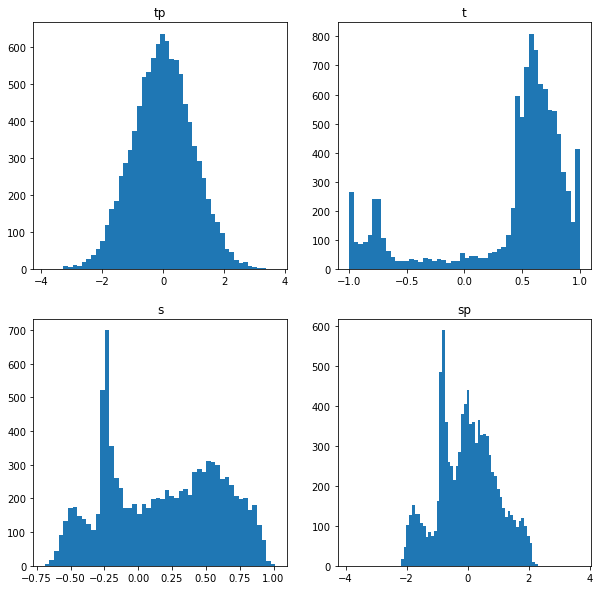

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, k in zip(axes.flat, ['tp', 't', 's', 'sp']):
    ax.hist(vals[k], bins=50)
    ax.set_title(k)
#     ax.set_yscale('log')
    
_= axes[1,1].set_xlim(*(axes[0, 0].get_xlim()))
plt.savefig('data_hists'+str(batch_size)+'_'+str(lr)+'_'+str(num_epochs)+'_'+str(ratio)+'_'+str(num_linspace)+'.png')

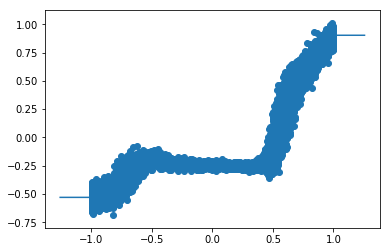

In [73]:
plt.plot(vs_data, mus_data)
plt.scatter(vals['t'], vals['s'])
plt.savefig('data_scatter'+str(batch_size)+'_'+str(lr)+'_'+str(num_epochs)+'_'+str(ratio)+'_'+str(num_linspace)+'.png')

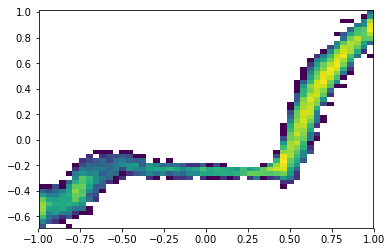

In [74]:
_ = plt.hist2d(vals['t'].ravel(), vals['s'].ravel(), bins=50, norm=LogNorm())

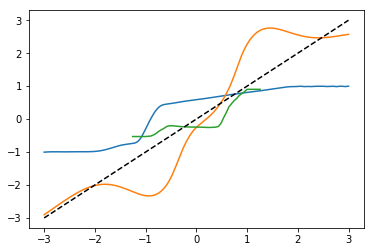

In [20]:
# plt.plot(xx, vals['y_encoder'], label='f')
# plt.plot(xx, vals['y_decoder'], label='h')
# plt.plot(vs_data, mus_data, label='g')
# plt.plot(xx, xx, 'k--', label='x')
# # plt.xlim(-1.5,1.5)
# # plt.ylim(-1.75,1.75)

In [25]:
f = interpolate.InterpolatedUnivariateSpline(xx, vals['y_encoder'], k=3)
g = interpolate.InterpolatedUnivariateSpline(vs_data, mus_data, k=3)
h = interpolate.InterpolatedUnivariateSpline(xx, vals['y_decoder'], k=3)

In [30]:
xs = linspace(xx[0][0],xx[-1][0], 1e3)

/Users/zarcone/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


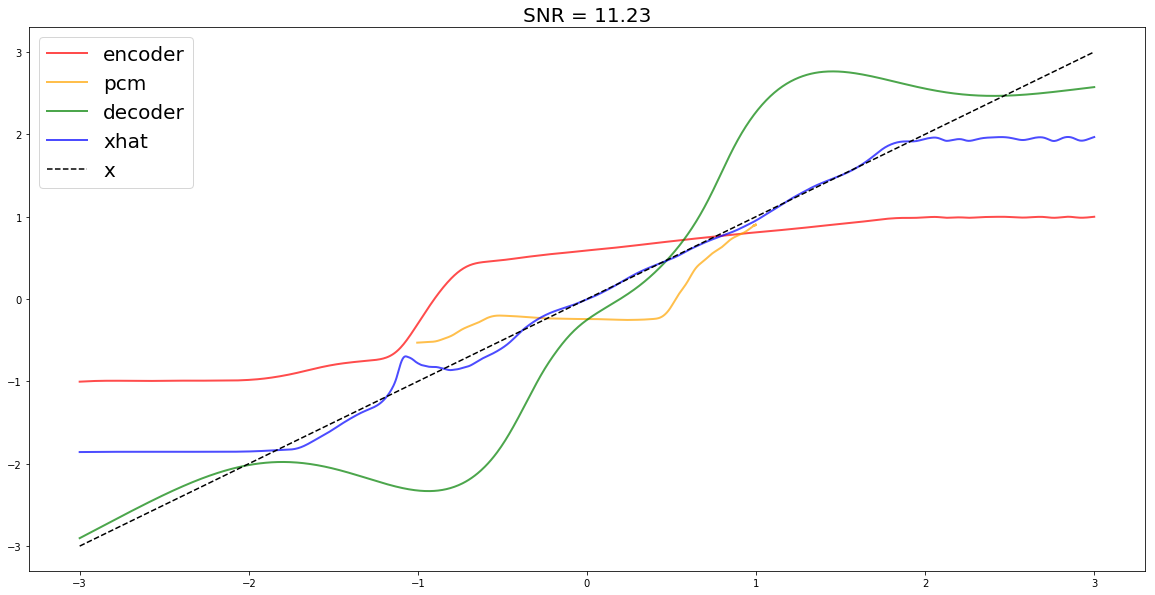

In [69]:
plt.figure(figsize=(20,10))
plt.plot(xs, f(xs), 'r', lw=2, alpha=0.7, label='encoder')
plt.plot(f(xs), g(f(xs)), c='orange', lw=2, alpha=0.7, label='pcm')
plt.plot(xs, h(xs), c='green', lw=2, alpha=0.7, label='decoder')
plt.plot(xs, h(g(f(xs))), c='blue', lw=2, alpha=0.7, label='xhat')
plt.plot(xx, xx, 'k--', label='x')
plt.title('SNR = '+str(round(10 * np.log10(1/vals['mse']),2)), fontsize=20)
legend(loc='upper left', fontsize=20)
plt.savefig('enc_dec_plot_'+str(batch_size)+'_'+str(lr)+'_'+str(num_epochs)+'_'+str(ratio)+'_'+str(num_linspace)+'.png')

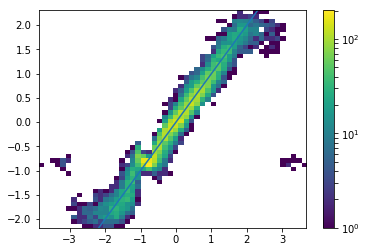

In [65]:
_ = plt.hist2d(vals['tp'].ravel(), vals['sp'].ravel(), bins=50, norm=LogNorm())
plt.plot(xx, xx)
plt.colorbar()
plt.savefig('x_xhat_hist'+str(batch_size)+'_'+str(lr)+'_'+str(num_epochs)+'_'+str(ratio)+'_'+str(num_linspace)+'.png')

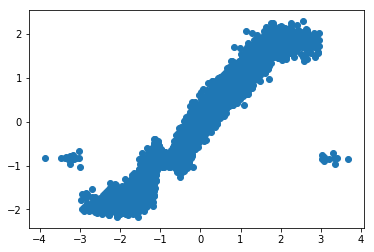

In [66]:
plt.scatter(vals['tp'].ravel(), vals['sp'].ravel())
plt.savefig('x_xhat_scatter'+str(batch_size)+'_'+str(lr)+'_'+str(num_epochs)+'_'+str(ratio)+'_'+str(num_linspace)+'.png')

In [ ]:
### PARAMS ###
"""
- epochs: 300 
- lr = 0.0005
- batch_size = 1000
- xx = np.linspace(-3, 3, 200)
- ratio=0.75
=> SNR = 11.6

n_m = 1
batch_size = 10000
lr = 0.0005
num_epochs=300
ratio = 0.75
xx = np.linspace(-3, 3, 200)
mem_path = 'data/Partial_Reset_PCM.pkl'
=> SNR = 11.2

- also look at verying out of bounds term
- put on redwood1 and run on gpu 
"""

In [79]:
from Jesse_Funcs_New import blahut

In [75]:
def super_channel(data_path, device_nums, diffs, colors, alphas):
    plt.figure(figsize=(20,10))
    V, R = get_data(data_path, plot_data = False, new_data = True, take_log = True, device_num = 0)
    R = R+diffs[0]
    for i in device_nums[1:]:
        V_new, R_new = get_data(data_path, plot_data = False, new_data = True, take_log = True, device_num = device_nums[i])
        V = np.append(V,V_new)
        R = np.append(R,R_new+diffs[i])
    plt.scatter(V,R)
    plt.savefig('super_channel.png')        
    
    plt.figure(figsize=(20,10))
    data_mean, data_std = blahut.moments(V, R)    
    new_Vs = np.linspace(np.amin(V), np.amax(V),len(data_mean))
    lower_Rs = data_mean-data_std
    upper_Rs = data_mean+data_std
    plt.fill_between(new_Vs, lower_Rs, upper_Rs, alpha=alphas[i], color=colors[i])
    plt.xlabel(r'V', fontsize=18)
    plt.ylabel(r'$\log _{ 10 }{ \left( R \right)  }$ ', fontsize=18)
    plt.savefig('super_channel_varr.png')        

    return V, R 

In [77]:
def get_data(data_path, plot_data = False, new_data = True, device_num=0, take_log = True):
    data = pd.read_pickle(data_path)
    
    if new_data:
        device_idx = [data['Device'] == device_num]
        V_device = np.array(data['V'][device_idx[0]])
        R_device = np.array(data['R'][device_idx[0]])
    else: 
        V_device = np.array(data['V'])
        R_device = np.array(data['R'])
    if plot_data:
        plt.figure(figsize=(20,10))
        plt.scatter(V_device,np.log10(R_device), c='green')
        
    if take_log:
        R_device = np.log10(R_device)
    
    return V_device, R_device

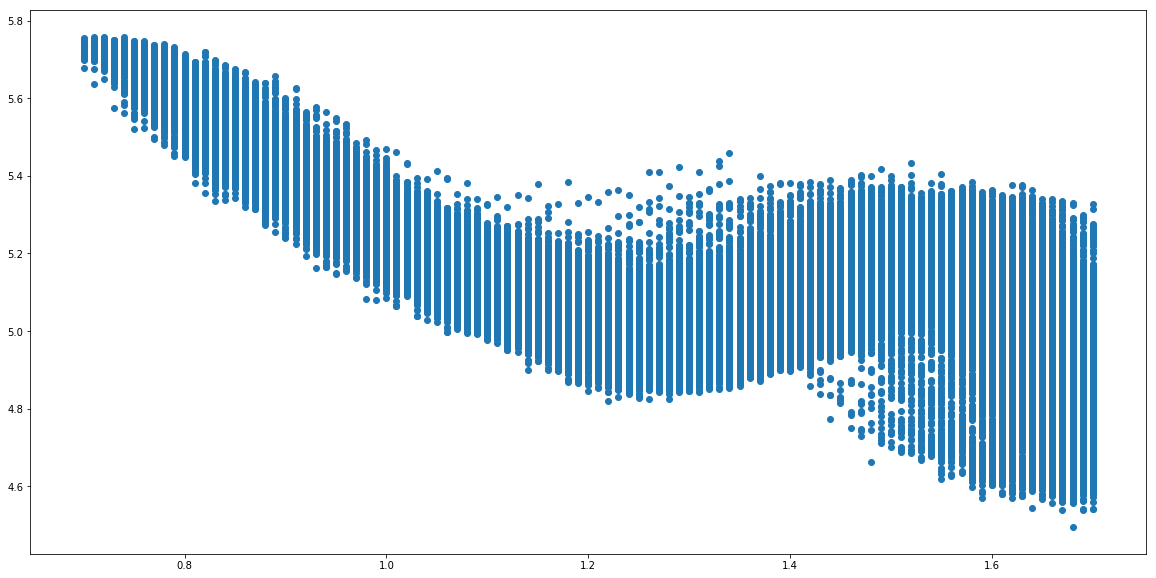

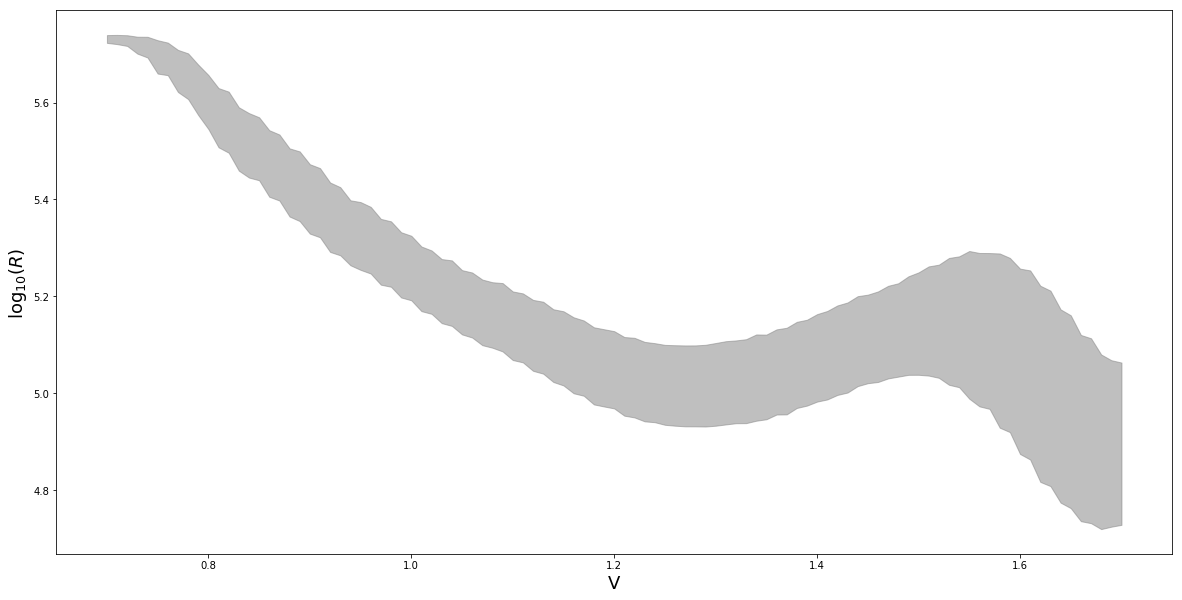

In [80]:
data_path = 'Data/PCM_20140605.pkl'
device_nums = np.arange(7)
diffs = np.array([0.32,0.4,0.12,0.115,0.235,0.0,0.26])
colors = ['red','orange','yellow','green','blue','purple','grey']
alphas = np.array([0.5]*7)


V_super, R_super = super_channel(data_path, device_nums, diffs, colors, alphas)